<a href="https://colab.research.google.com/github/nasare34/FUTransUNet-Foot-Ulcer-Segmentation/blob/main/FUTransUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imgaug


In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

# STEP 2: Set dataset path
# Adjust BASE_DIR to where your dataset is stored
BASE_DIR = '/content/drive/MyDrive/data/FootUlcerSegmentationChallenge'

TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, 'train/images')
TRAIN_LABEL_DIR = os.path.join(BASE_DIR, 'train/labels')
VAL_IMAGE_DIR = os.path.join(BASE_DIR, 'validation/images')
VAL_LABEL_DIR = os.path.join(BASE_DIR, 'validation/labels')
TEST_IMAGE_DIR = os.path.join(BASE_DIR, 'test/images')  # Updated path

# Output directory for predictions
PRED_DIR = os.path.join(BASE_DIR, 'test/predictions')
os.makedirs(PRED_DIR, exist_ok=True)

# Confirm paths
print("Train images:", TRAIN_IMAGE_DIR)
print("Train labels:", TRAIN_LABEL_DIR)
print("Validation images:", VAL_IMAGE_DIR)
print("Validation labels:", VAL_LABEL_DIR)
print("Test images:", TEST_IMAGE_DIR)


Mounted at /content/drive
Train images: /content/drive/MyDrive/data/FootUlcerSegmentationChallenge/train/images
Train labels: /content/drive/MyDrive/data/FootUlcerSegmentationChallenge/train/labels
Validation images: /content/drive/MyDrive/data/FootUlcerSegmentationChallenge/validation/images
Validation labels: /content/drive/MyDrive/data/FootUlcerSegmentationChallenge/validation/labels
Test images: /content/drive/MyDrive/data/FootUlcerSegmentationChallenge/test/images


# TRANSUNET ARCHITECTURE

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class Unet2D:
    def __init__(self, n_filters=32, input_dim_x=512, input_dim_y=512, num_channels=3,
                 transformer_depth=6, num_attention_heads=8):
        self.n_filters = n_filters
        self.input_dim_x = input_dim_x
        self.input_dim_y = input_dim_y
        self.num_channels = num_channels
        self.transformer_depth = transformer_depth
        self.num_attention_heads = num_attention_heads

    def conv_block(self, x, n_filters):
        x = layers.Conv2D(n_filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(n_filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def transformer_block(self, x, patch_size=16):
        # Flatten patches
        _, h, w, c = x.shape
        num_patches = (h // patch_size) * (w // patch_size)
        projection_dim = self.n_filters

        x = layers.Conv2D(projection_dim, patch_size, strides=patch_size, padding='valid')(x)
        x = layers.Reshape((num_patches, projection_dim))(x)

        # Positional Encoding
        pos_emb = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        positions = tf.range(start=0, limit=num_patches, delta=1)
        x = x + pos_emb(positions)

        # Transformer layers
        for _ in range(self.transformer_depth):
            # Multi-head self attention
            attn_output = layers.MultiHeadAttention(num_heads=self.num_attention_heads, key_dim=projection_dim)(x, x)
            x = layers.LayerNormalization()(x + attn_output)

            # MLP
            ffn = models.Sequential([
                layers.Dense(projection_dim * 4, activation='gelu'),
                layers.Dense(projection_dim)
            ])
            x = layers.LayerNormalization()(x + ffn(x))

        # Reshape back to feature map
        size = h // patch_size
        x = layers.Reshape((size, size, projection_dim))(x)
        x = layers.UpSampling2D(size=(patch_size, patch_size))(x)
        return x

    def get_vit_unet_model(self):
        inputs = layers.Input(shape=(self.input_dim_x, self.input_dim_y, self.num_channels))

        # Encoder
        c1 = self.conv_block(inputs, self.n_filters)
        p1 = layers.MaxPooling2D((2, 2))(c1)

        c2 = self.conv_block(p1, self.n_filters * 2)
        p2 = layers.MaxPooling2D((2, 2))(c2)

        c3 = self.conv_block(p2, self.n_filters * 4)
        p3 = layers.MaxPooling2D((2, 2))(c3)

        c4 = self.conv_block(p3, self.n_filters * 8)
        p4 = layers.MaxPooling2D((2, 2))(c4)

        # Bottleneck with ViT
        vit = self.transformer_block(p4, patch_size=16)

        # Decoder
        u1 = layers.UpSampling2D((2, 2))(vit)
        u1 = layers.Concatenate()([u1, c4])
        u1 = self.conv_block(u1, self.n_filters * 8)

        u2 = layers.UpSampling2D((2, 2))(u1)
        u2 = layers.Concatenate()([u2, c3])
        u2 = self.conv_block(u2, self.n_filters * 4)

        u3 = layers.UpSampling2D((2, 2))(u2)
        u3 = layers.Concatenate()([u3, c2])
        u3 = self.conv_block(u3, self.n_filters * 2)

        u4 = layers.UpSampling2D((2, 2))(u3)
        u4 = layers.Concatenate()([u4, c1])
        u4 = self.conv_block(u4, self.n_filters)

        # Output layer with sigmoid for binary mask
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u4)

        model = models.Model(inputs=inputs, outputs=outputs)
        return model, "vit_unet_model"


ORIGINAL IMAGE SIZE CHECK

In [ ]:
import os
import cv2

def check_image_sizes(folder, max_images=10):
    image_files = sorted(os.listdir(folder))[:max_images]

    for fname in image_files:
        fpath = os.path.join(folder, fname)
        img = cv2.imread(fpath)
        if img is not None:
            h, w, c = img.shape
            print(f"{fname}: {w} x {h} (Channels: {c})")
        else:
            print(f"Could not read {fname}")

# Call it on your test image directory
check_image_sizes(TEST_IMAGE_DIR)


1011.png: 512 x 512 (Channels: 3)
1014.png: 512 x 512 (Channels: 3)
1016.png: 512 x 512 (Channels: 3)
1018.png: 512 x 512 (Channels: 3)
1020.png: 512 x 512 (Channels: 3)
1021.png: 512 x 512 (Channels: 3)
1022.png: 512 x 512 (Channels: 3)
1024.png: 512 x 512 (Channels: 3)
1028.png: 512 x 512 (Channels: 3)
1029.png: 512 x 512 (Channels: 3)


#DATAGENERATOR

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class FootUlcerDataGenerator(Sequence):
    def __init__(self, image_dir, label_dir=None, batch_size=8, image_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.image_size = image_size  # (width, height)
        self.shuffle = shuffle

        self.image_filenames = sorted([
            f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))
        ])

        if label_dir:
            self.label_filenames = sorted([
                f for f in os.listdir(label_dir) if f.endswith(('.png', '.jpg', '.jpeg'))
            ])
        else:
            self.label_filenames = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        X = []
        y = []

        for filename in batch_images:
            # Load and preprocess image
            img_path = os.path.join(self.image_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.image_size)
            img = img.astype(np.float32) / 255.0
            X.append(img)

            # Load and preprocess corresponding mask
            if self.label_dir:
                mask_path = os.path.join(self.label_dir, filename)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
                mask = (mask > 127).astype(np.float32)  # Binarize
                mask = np.expand_dims(mask, axis=-1)    # Shape: (H, W, 1)
                y.append(mask)

        X = np.array(X)

        if self.label_dir:
            y = np.array(y)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        if self.shuffle:
            if self.label_filenames:
                temp = list(zip(self.image_filenames, self.label_filenames))
                np.random.shuffle(temp)
                self.image_filenames, self.label_filenames = zip(*temp)
                self.image_filenames = list(self.image_filenames)
                self.label_filenames = list(self.label_filenames)
            else:
                np.random.shuffle(self.image_filenames)


INIATIALIZATION

In [ ]:
# Define batch size and image resolution
BATCH_SIZE = 16
IMG_SIZE = (256, 256)  # Keep original resolution (512x512)

# Initialize the training data generator
train_gen = FootUlcerDataGenerator(
    image_dir=TRAIN_IMAGE_DIR,
    label_dir=TRAIN_LABEL_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True  # Shuffle training data
)

# Initialize the validation data generator
val_gen = FootUlcerDataGenerator(
    image_dir=VAL_IMAGE_DIR,
    label_dir=VAL_LABEL_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)


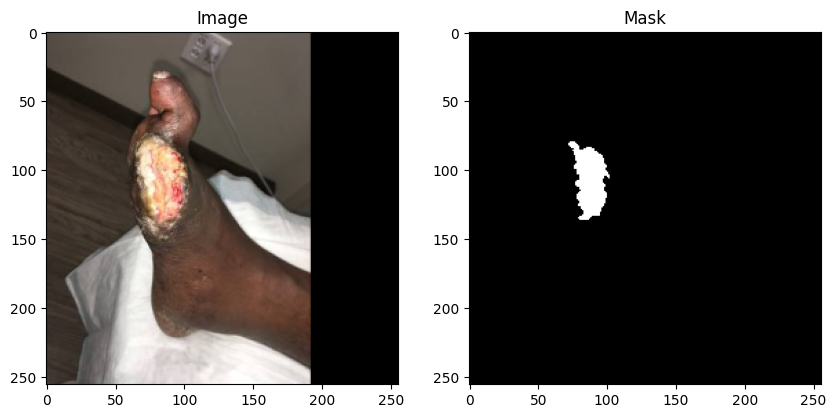

In [ ]:
X_batch, y_batch = train_gen[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(X_batch[0])

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(y_batch[0].squeeze(), cmap='gray')

plt.show()


#TRAINING MODEL

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf

# --- Custom Metrics ---
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# --- Instantiate ViT + U-Net Model ---
unet_obj = Unet2D(
    n_filters=32,
    input_dim_x=256,
    input_dim_y=256,
    num_channels=3,
    transformer_depth=6,           # Increased depth
    num_attention_heads=8          # Increased attention heads
)
model, model_name = unet_obj.get_vit_unet_model()

# --- Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy', dice_coefficient, iou_metric]
)

# --- Callbacks ---
checkpoint_cb = ModelCheckpoint(
    filepath=f'/content/{model_name}.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1
)

early_stop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# --- Train Model ---
EPOCHS = 50

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stop_cb]
)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.9587 - dice_coefficient: 0.0484 - iou_metric: 0.0249 - loss: 0.2822
Epoch 1: val_loss improved from inf to 0.58247, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9592 - dice_coefficient: 0.0486 - iou_metric: 0.0250 - loss: 0.2806 - val_accuracy: 0.9056 - val_dice_coefficient: 0.0202 - val_iou_metric: 0.0102 - val_loss: 0.5825 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9889 - dice_coefficient: 0.0958 - iou_metric: 0.0506 - loss: 0.1112
Epoch 2: val_loss improved from 0.58247 to 0.21462, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 355ms/step - accuracy: 0.9889 - dice_coefficient: 0.0961 - iou_metric: 0.0507 - loss: 0.1110 - val_accuracy: 0.9878 - val_dice_coefficient: 0.0273 - val_iou_metric: 0.0138 - val_loss: 0.2146 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9896 - dice_coefficient: 0.1412 - iou_metric: 0.0765 - loss: 0.0725
Epoch 3: val_loss improved from 0.21462 to 0.08941, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.9896 - dice_coefficient: 0.1416 - iou_metric: 0.0767 - loss: 0.0724 - val_accuracy: 0.9878 - val_dice_coefficient: 0.0229 - val_iou_metric: 0.0116 - val_loss: 0.0894 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9912 - dice_coefficient: 0.1926 - iou_metric: 0.1075 - loss: 0.0533
Epoch 4: val_loss improved from 0.08941 to 0.07334, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.9912 - dice_coefficient: 0.1932 - iou_metric: 0.1079 - loss: 0.0533 - val_accuracy: 0.9878 - val_dice_coefficient: 0.0239 - val_iou_metric: 0.0121 - val_loss: 0.0733 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9910 - dice_coefficient: 0.2874 - iou_metric: 0.1688 - loss: 0.0436
Epoch 5: val_loss improved from 0.07334 to 0.06639, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - accuracy: 0.9910 - dice_coefficient: 0.2872 - iou_metric: 0.1687 - loss: 0.0435 - val_accuracy: 0.9878 - val_dice_coefficient: 0.0405 - val_iou_metric: 0.0207 - val_loss: 0.0664 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9918 - dice_coefficient: 0.3176 - iou_metric: 0.1900 - loss: 0.0359
Epoch 6: val_loss improved from 0.06639 to 0.06553, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 362ms/step - accuracy: 0.9918 - dice_coefficient: 0.3180 - iou_metric: 0.1903 - loss: 0.0359 - val_accuracy: 0.9878 - val_dice_coefficient: 0.0160 - val_iou_metric: 0.0081 - val_loss: 0.0655 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9921 - dice_coefficient: 0.3679 - iou_metric: 0.2273 - loss: 0.0316
Epoch 7: val_loss improved from 0.06553 to 0.06213, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.9921 - dice_coefficient: 0.3680 - iou_metric: 0.2274 - loss: 0.0316 - val_accuracy: 0.9878 - val_dice_coefficient: 0.0257 - val_iou_metric: 0.0132 - val_loss: 0.0621 - learning_rate: 0.0010
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9923 - dice_coefficient: 0.4076 - iou_metric: 0.2582 - loss: 0.0282
Epoch 8: val_loss did not improve from 0.06213
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - accuracy: 0.9923 - dice_coefficient: 0.4076 - iou_metric: 0.2582 - loss: 0.0282 - val_accuracy: 0.9878 - val_dice_coefficient: 0.0345 - val_iou_metric: 0.0179 - val_loss: 0.0644 - learning_rate: 0.0010
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9923 - dice_coefficient: 0.4169 - iou_metric: 0.2648 - loss: 0.0273
Epoch 9: val_loss did not improve from 0.06213
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - accuracy: 0.9923 - dice_coefficient: 0.4173 - iou_metric: 0.2651 - loss: 0.0273 - val_accuracy: 0.9861

51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 363ms/step - accuracy: 0.9925 - dice_coefficient: 0.4734 - iou_metric: 0.3130 - loss: 0.0248 - val_accuracy: 0.9907 - val_dice_coefficient: 0.3171 - val_iou_metric: 0.1911 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9939 - dice_coefficient: 0.5246 - iou_metric: 0.3577 - loss: 0.0209
Epoch 11: val_loss improved from 0.03761 to 0.02624, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 363ms/step - accuracy: 0.9939 - dice_coefficient: 0.5244 - iou_metric: 0.3575 - loss: 0.0209 - val_accuracy: 0.9917 - val_dice_coefficient: 0.4373 - val_iou_metric: 0.2820 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9928 - dice_coefficient: 0.4821 - iou_metric: 0.3219 - loss: 0.0232
Epoch 12: val_loss improved from 0.02624 to 0.02153, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9928 - dice_coefficient: 0.4828 - iou_metric: 0.3224 - loss: 0.0232 - val_accuracy: 0.9934 - val_dice_coefficient: 0.5488 - val_iou_metric: 0.3804 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 13/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9942 - dice_coefficient: 0.5601 - iou_metric: 0.3915 - loss: 0.0184
Epoch 13: val_loss improved from 0.02153 to 0.02069, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 364ms/step - accuracy: 0.9942 - dice_coefficient: 0.5603 - iou_metric: 0.3917 - loss: 0.0184 - val_accuracy: 0.9935 - val_dice_coefficient: 0.5514 - val_iou_metric: 0.3824 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 14/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9946 - dice_coefficient: 0.5715 - iou_metric: 0.4046 - loss: 0.0170
Epoch 14: val_loss did not improve from 0.02069
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - accuracy: 0.9946 - dice_coefficient: 0.5720 - iou_metric: 0.4051 - loss: 0.0170 - val_accuracy: 0.9909 - val_dice_coefficient: 0.5402 - val_iou_metric: 0.3721 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 15/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9946 - dice_coefficient: 0.6055 - iou_metric: 0.4372 - loss: 0.0167
Epoch 15: val_loss improved from 0.02069 to 0.01876, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 365ms/step - accuracy: 0.9946 - dice_coefficient: 0.6055 - iou_metric: 0.4372 - loss: 0.0167 - val_accuracy: 0.9938 - val_dice_coefficient: 0.6097 - val_iou_metric: 0.4416 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 16/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9943 - dice_coefficient: 0.6208 - iou_metric: 0.4534 - loss: 0.0170
Epoch 16: val_loss did not improve from 0.01876
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.9943 - dice_coefficient: 0.6207 - iou_metric: 0.4533 - loss: 0.0170 - val_accuracy: 0.9933 - val_dice_coefficient: 0.5405 - val_iou_metric: 0.3757 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 17/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9949 - dice_coefficient: 0.6309 - iou_metric: 0.4630 - loss: 0.0156
Epoch 17: val_loss improved from 0.01876 to 0.01669, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.9949 - dice_coefficient: 0.6311 - iou_metric: 0.4632 - loss: 0.0156 - val_accuracy: 0.9942 - val_dice_coefficient: 0.6484 - val_iou_metric: 0.4821 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 18/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9956 - dice_coefficient: 0.6856 - iou_metric: 0.5242 - loss: 0.0132
Epoch 18: val_loss did not improve from 0.01669
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.9956 - dice_coefficient: 0.6854 - iou_metric: 0.5239 - loss: 0.0132 - val_accuracy: 0.9941 - val_dice_coefficient: 0.6212 - val_iou_metric: 0.4560 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 19/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9949 - dice_coefficient: 0.6593 - iou_metric: 0.4954 - loss: 0.0154
Epoch 19: val_loss improved from 0.01669 to 0.01505, saving model to /content/vit_unet_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9949 - dice_coefficient: 0.6592 - iou_metric: 0.4952 - loss: 0.0154 - val_accuracy: 0.9949 - val_dice_coefficient: 0.6583 - val_iou_metric: 0.4926 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 20/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9954 - dice_coefficient: 0.6820 - iou_metric: 0.5208 - loss: 0.0132
Epoch 20: val_loss did not improve from 0.01505
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.9954 - dice_coefficient: 0.6819 - iou_metric: 0.5207 - loss: 0.0132 - val_accuracy: 0.9944 - val_dice_coefficient: 0.6466 - val_iou_metric: 0.4822 - val_loss: 0.0174 - learning_rate: 0.0010
Epoch 21/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9962 - dice_coefficient: 0.7072 - iou_metric: 0.5488 - loss: 0.0111
Epoch 21: val_loss did not improve from 0.01505
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.9962 - dice_coefficient: 0.7073 - iou_metric: 0.5489 - loss: 0.0111 - val_accuracy: 0.

51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9971 - dice_coefficient: 0.7884 - iou_metric: 0.6526 - loss: 0.0085 - val_accuracy: 0.9960 - val_dice_coefficient: 0.7367 - val_iou_metric: 0.5851 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 27/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9968 - dice_coefficient: 0.7754 - iou_metric: 0.6356 - loss: 0.0090
Epoch 27: val_loss did not improve from 0.01148
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.9968 - dice_coefficient: 0.7752 - iou_metric: 0.6353 - loss: 0.0090 - val_accuracy: 0.9933 - val_dice_coefficient: 0.6291 - val_iou_metric: 0.4610 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 28/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9964 - dice_coefficient: 0.7495 - iou_metric: 0.6014 - loss: 0.0102
Epoch 28: val_loss did not improve from 0.01148
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 357ms/step - accuracy: 0.9964 - dice_coefficient: 0.7494 - iou_metric: 0.6013 - loss: 0.0102 - val_accuracy: 0.

51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9967 - dice_coefficient: 0.7826 - iou_metric: 0.6447 - loss: 0.0088 - val_accuracy: 0.9963 - val_dice_coefficient: 0.7526 - val_iou_metric: 0.6052 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 31/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9974 - dice_coefficient: 0.8106 - iou_metric: 0.6827 - loss: 0.0073
Epoch 31: val_loss did not improve from 0.01108
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.9974 - dice_coefficient: 0.8105 - iou_metric: 0.6827 - loss: 0.0073 - val_accuracy: 0.9951 - val_dice_coefficient: 0.6718 - val_iou_metric: 0.5105 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 32/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9972 - dice_coefficient: 0.8126 - iou_metric: 0.6857 - loss: 0.0077
Epoch 32: val_loss did not improve from 0.01108
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.9972 - dice_coefficient: 0.8123 - iou_metric: 0.6854 - loss: 0.0077 - val_accuracy: 0.

51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9976 - dice_coefficient: 0.8308 - iou_metric: 0.7128 - loss: 0.0066 - val_accuracy: 0.9969 - val_dice_coefficient: 0.8143 - val_iou_metric: 0.6885 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 40/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9978 - dice_coefficient: 0.8473 - iou_metric: 0.7361 - loss: 0.0059
Epoch 40: val_loss did not improve from 0.00951
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 361ms/step - accuracy: 0.9978 - dice_coefficient: 0.8474 - iou_metric: 0.7362 - loss: 0.0059 - val_accuracy: 0.9969 - val_dice_coefficient: 0.7924 - val_iou_metric: 0.6578 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 41/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9980 - dice_coefficient: 0.8645 - iou_metric: 0.7620 - loss: 0.0055
Epoch 41: val_loss did not improve from 0.00951
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 357ms/step - accuracy: 0.9980 - dice_coefficient: 0.8645 - iou_metric: 0.7619 - loss: 0.0055 - val_accuracy: 0.

51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9979 - dice_coefficient: 0.8651 - iou_metric: 0.7634 - loss: 0.0054 - val_accuracy: 0.9971 - val_dice_coefficient: 0.8342 - val_iou_metric: 0.7167 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 46/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9978 - dice_coefficient: 0.8587 - iou_metric: 0.7548 - loss: 0.0059
Epoch 46: val_loss did not improve from 0.00904
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - accuracy: 0.9977 - dice_coefficient: 0.8581 - iou_metric: 0.7538 - loss: 0.0059 - val_accuracy: 0.9941 - val_dice_coefficient: 0.6492 - val_iou_metric: 0.4858 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 47/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9968 - dice_coefficient: 0.8011 - iou_metric: 0.6703 - loss: 0.0086
Epoch 47: val_loss did not improve from 0.00904
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 357ms/step - accuracy: 0.9968 - dice_coefficient: 0.8011 - iou_metric: 0.6702 - loss: 0.0086 - val_accuracy: 0.

# Plot Training History

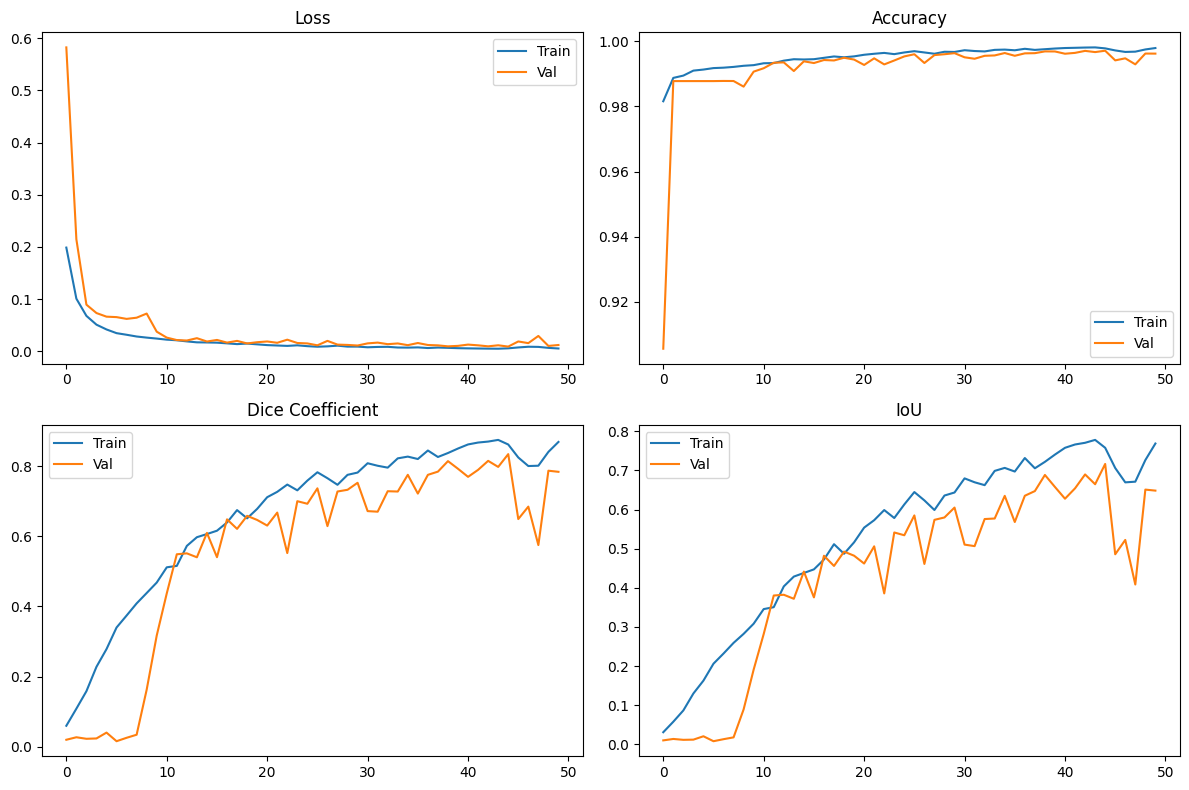

In [ ]:
# Plot training & validation loss and metrics
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

# Dice Coefficient
plt.subplot(2, 2, 3)
plt.plot(history.history['dice_coefficient'], label='Train')
plt.plot(history.history['val_dice_coefficient'], label='Val')
plt.title('Dice Coefficient')
plt.legend()

# IoU
plt.subplot(2, 2, 4)
plt.plot(history.history['iou_metric'], label='Train')
plt.plot(history.history['val_iou_metric'], label='Val')
plt.title('IoU')
plt.legend()

plt.tight_layout()
plt.show()


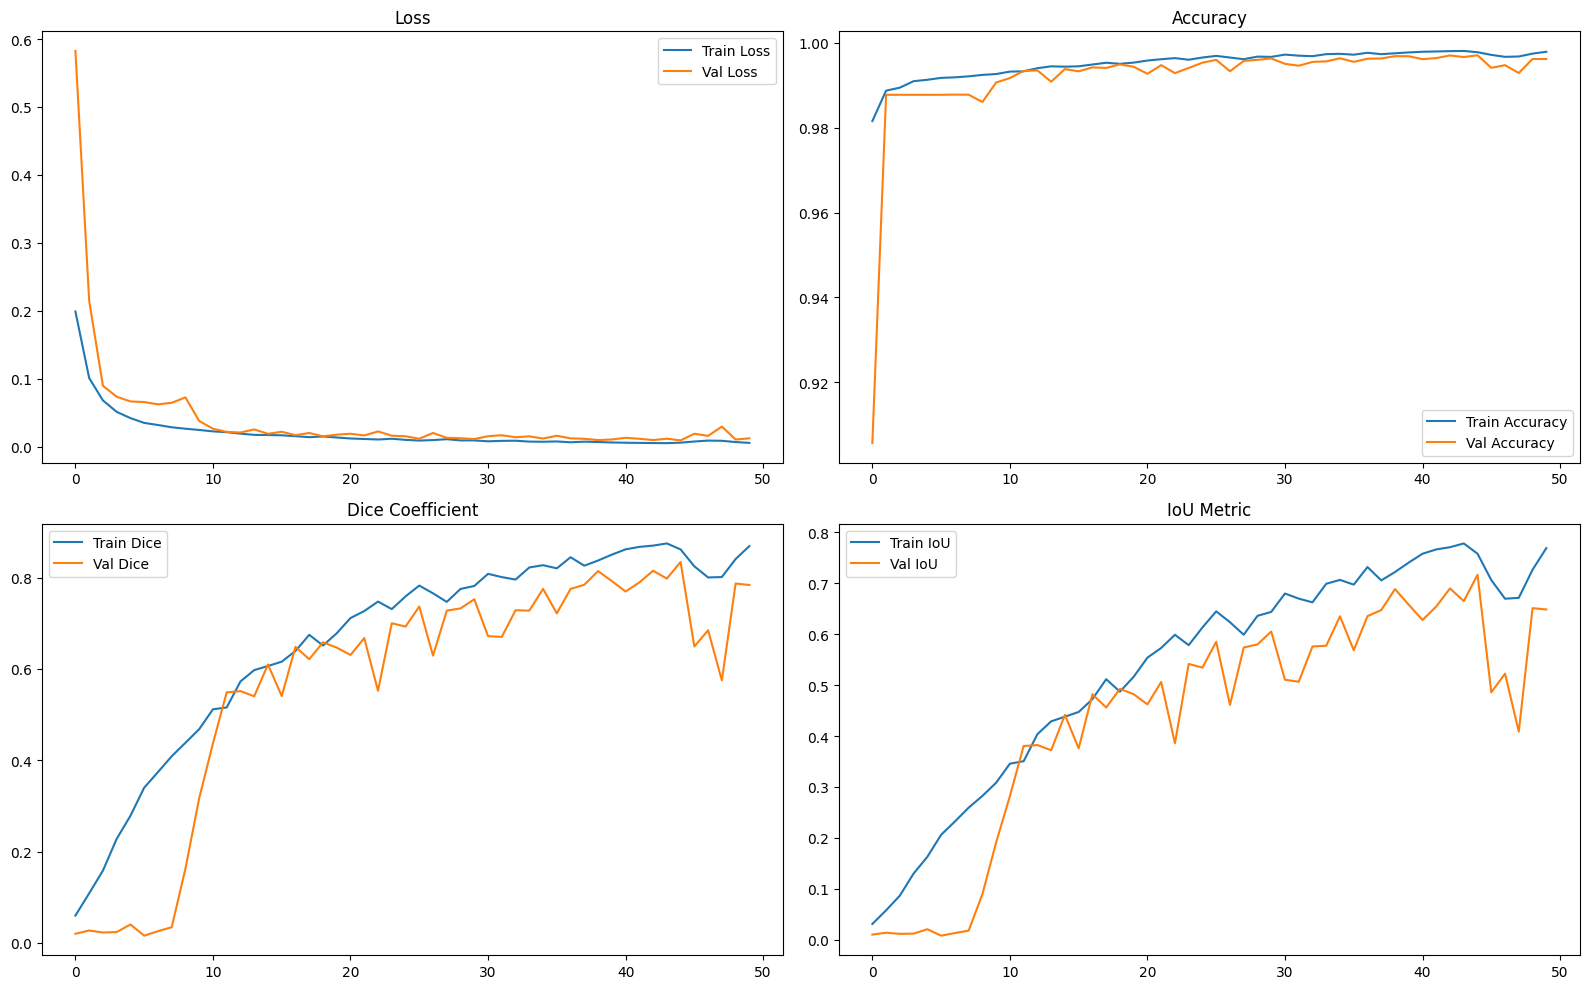

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(16, 10))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Dice Coefficient
    plt.subplot(2, 2, 3)
    plt.plot(history.history['dice_coefficient'], label='Train Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.legend()

    # IoU
    plt.subplot(2, 2, 4)
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Val IoU')
    plt.title('IoU Metric')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call it
plot_training_curves(history)


Predict on the Test Set and Save Masks

In [ ]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load trained model
model.load_weights(f'/content/{model_name}.h5')

# Load test generator (no labels)
test_gen = FootUlcerDataGenerator(
    image_dir=TEST_IMAGE_DIR,
    label_dir=None,
    batch_size=1,
    image_size=(256, 256),
    shuffle=False
)

# Run inference and save predicted masks
for idx in tqdm(range(len(test_gen))):
    images = test_gen[idx]
    preds = model.predict(images)
    preds = (preds[0] > 0.5).astype(np.uint8) * 255  # Binarize and scale to 0-255

    # Save prediction
    filename = test_gen.image_filenames[idx]
    save_path = os.path.join(PRED_DIR, filename)
    cv2.imwrite(save_path, preds.squeeze())  # Remove channel dimension


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 1/200 [00:00<00:24,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  2%|▏         | 3/200 [00:00<00:31,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|▎         | 5/200 [00:00<00:24,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 6/200 [00:00<00:23,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▍         | 8/200 [00:00<00:21,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▌         | 10/200 [00:01<00:19,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▌         | 11/200 [00:01<00:44,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|▋         | 13/200 [00:02<00:33,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 15/200 [00:02<00:47,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 16/200 [00:03<01:02,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▉         | 18/200 [00:04<01:01,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|▉         | 19/200 [00:04<01:09,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|█         | 20/200 [00:05<01:18,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|█         | 22/200 [00:05<00:53,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|█▏        | 23/200 [00:06<01:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 24/200 [00:06<00:54,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▎        | 25/200 [00:07<01:21,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 26/200 [00:07<01:36,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█▎        | 27/200 [00:08<01:45,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▍        | 28/200 [00:09<01:43,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█▍        | 29/200 [00:10<02:03,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 30/200 [00:11<02:44,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 31/200 [00:12<02:23,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▋        | 33/200 [00:12<01:25,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 34/200 [00:12<01:08,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 35/200 [00:14<01:51,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 36/200 [00:14<01:53,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 37/200 [00:15<01:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▉        | 38/200 [00:16<01:57,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|█▉        | 39/200 [00:17<01:53,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 41/200 [00:17<01:08,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|██        | 42/200 [00:18<01:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 43/200 [00:19<01:41,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 44/200 [00:20<01:45,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|██▎       | 45/200 [00:20<01:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▎       | 47/200 [00:21<01:20,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▍       | 49/200 [00:21<00:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▌       | 50/200 [00:22<01:09,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██▌       | 52/200 [00:22<00:47,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▋       | 53/200 [00:23<01:04,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██▋       | 54/200 [00:24<01:14,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 55/200 [00:24<00:59,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██▊       | 57/200 [00:25<00:57,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|██▉       | 59/200 [00:25<00:41,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███       | 61/200 [00:26<00:43,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 62/200 [00:26<00:54,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 63/200 [00:27<00:58,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▎      | 65/200 [00:28<01:01,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 66/200 [00:28<01:04,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▎      | 67/200 [00:29<00:52,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 68/200 [00:29<00:57,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 70/200 [00:30<00:54,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 71/200 [00:31<01:02,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▋      | 73/200 [00:31<00:41,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 75/200 [00:31<00:30,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 76/200 [00:32<00:40,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███▉      | 78/200 [00:32<00:29,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|████      | 80/200 [00:33<00:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 81/200 [00:33<00:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 82/200 [00:35<01:12,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 84/200 [00:35<00:47,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▎     | 85/200 [00:36<00:53,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 86/200 [00:36<01:01,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 88/200 [00:37<00:40,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 89/200 [00:37<00:51,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 91/200 [00:38<00:46,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|████▌     | 92/200 [00:38<00:38,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|████▋     | 93/200 [00:39<00:47,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 95/200 [00:39<00:31,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 97/200 [00:40<00:32,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 99/200 [00:40<00:32,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 101/200 [00:41<00:24,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 102/200 [00:41<00:21,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|█████▏    | 104/200 [00:41<00:24,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▎    | 105/200 [00:42<00:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▎    | 107/200 [00:43<00:32,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▍    | 108/200 [00:44<00:40,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 110/200 [00:44<00:28,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 111/200 [00:44<00:32,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▌    | 112/200 [00:45<00:40,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 114/200 [00:45<00:27,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▊    | 115/200 [00:45<00:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 58%|█████▊    | 117/200 [00:46<00:25,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 118/200 [00:47<00:35,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|█████▉    | 119/200 [00:48<00:37,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|██████    | 120/200 [00:48<00:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 121/200 [00:48<00:33,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|██████    | 122/200 [00:49<00:36,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 124/200 [00:50<00:34,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 126/200 [00:51<00:32,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▎   | 127/200 [00:51<00:37,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 128/200 [00:52<00:37,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 129/200 [00:52<00:29,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 131/200 [00:53<00:27,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▋   | 133/200 [00:54<00:25,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 135/200 [00:54<00:23,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 136/200 [00:55<00:29,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 137/200 [00:56<00:31,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 138/200 [00:57<00:38,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|███████   | 140/200 [00:58<00:32,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|███████   | 141/200 [00:58<00:33,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 142/200 [00:58<00:26,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 143/200 [00:59<00:28,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 144/200 [00:59<00:22,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▎  | 145/200 [01:00<00:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 146/200 [01:01<00:30,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▎  | 147/200 [01:01<00:30,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 148/200 [01:02<00:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 150/200 [01:02<00:19,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 152/200 [01:02<00:13,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▋  | 153/200 [01:03<00:16,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|███████▊  | 155/200 [01:04<00:17,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 157/200 [01:05<00:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|███████▉  | 159/200 [01:05<00:15,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 161/200 [01:06<00:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 162/200 [01:06<00:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 163/200 [01:06<00:11,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 164/200 [01:07<00:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|████████▎ | 165/200 [01:08<00:16,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 83%|████████▎ | 166/200 [01:08<00:12,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████▎ | 167/200 [01:09<00:15,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 168/200 [01:09<00:18,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 169/200 [01:10<00:18,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 171/200 [01:11<00:15,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▋ | 173/200 [01:12<00:12,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 174/200 [01:12<00:12,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 175/200 [01:13<00:12,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 176/200 [01:13<00:12,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 178/200 [01:14<00:07,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 179/200 [01:14<00:08,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|█████████ | 180/200 [01:15<00:10,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|█████████ | 181/200 [01:16<00:10,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 183/200 [01:16<00:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 184/200 [01:17<00:07,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▎| 185/200 [01:17<00:07,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 186/200 [01:18<00:07,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▎| 187/200 [01:19<00:07,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 188/200 [01:19<00:06,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 190/200 [01:20<00:04,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 192/200 [01:21<00:03,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 194/200 [01:21<00:02,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 195/200 [01:22<00:02,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 196/200 [01:23<00:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▉| 198/200 [01:24<00:01,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|█████████▉| 199/200 [01:24<00:00,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


Visualize Input and Prediction Side-by-Side

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


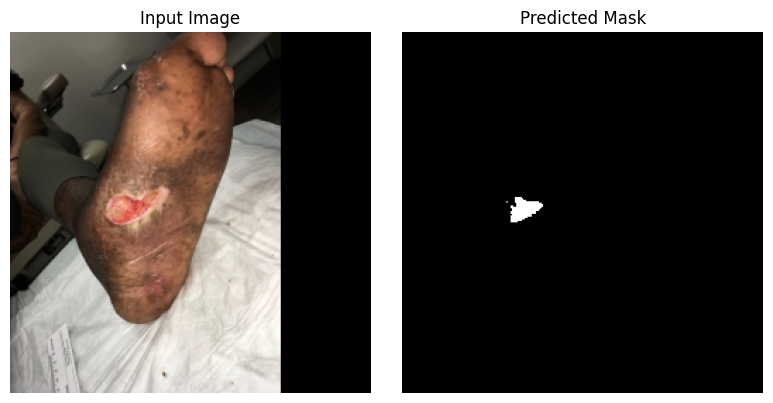

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


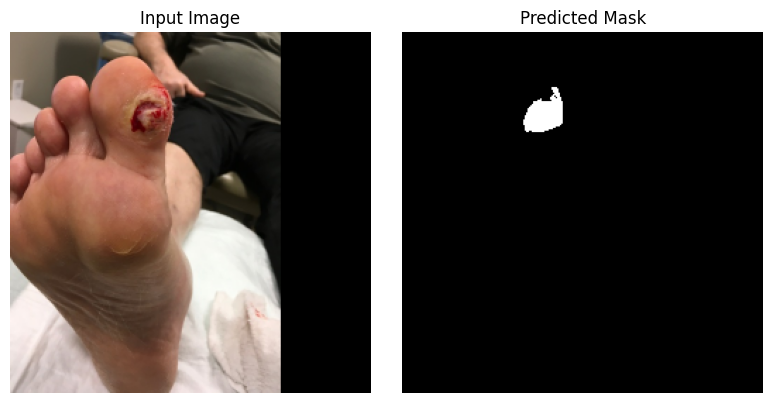

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


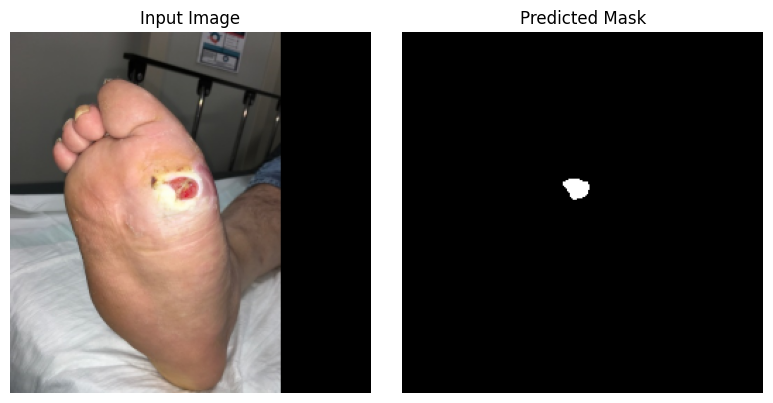

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


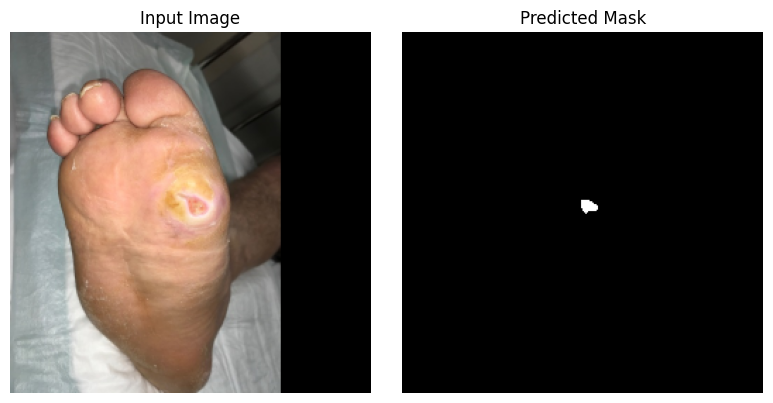

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


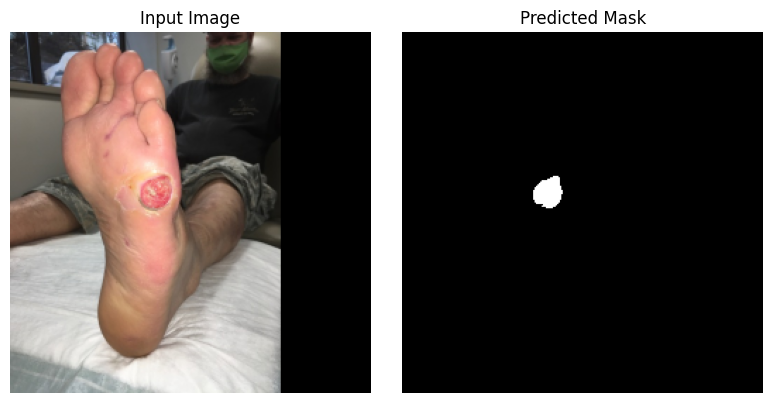

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


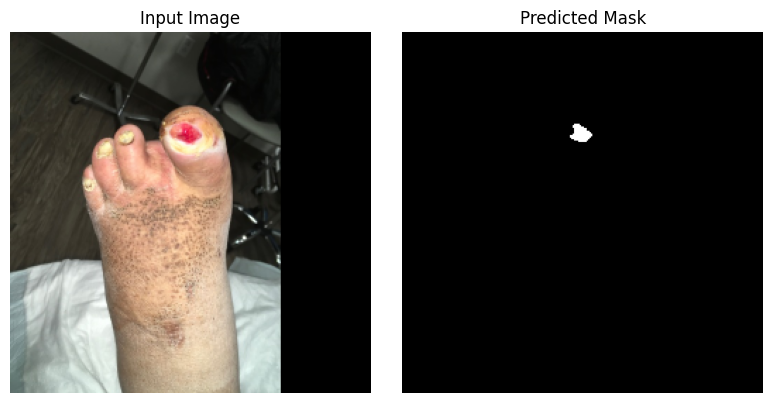

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


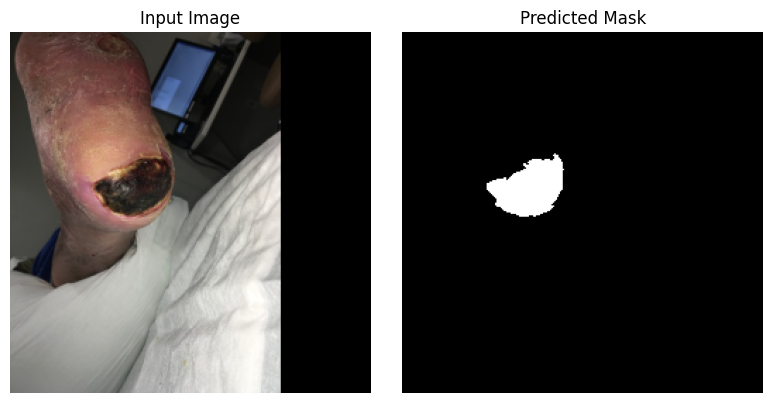

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


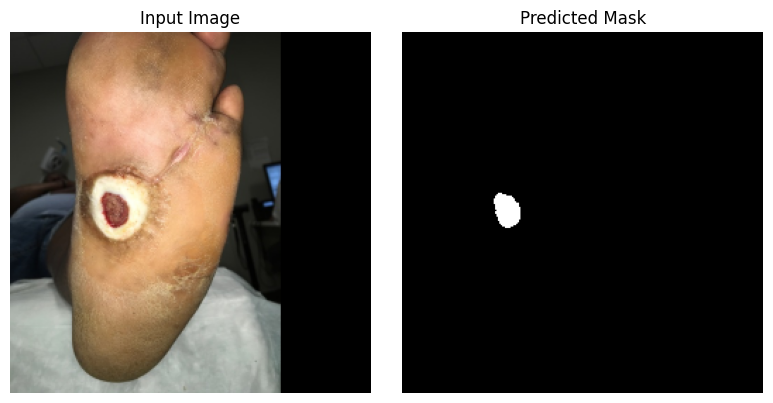

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


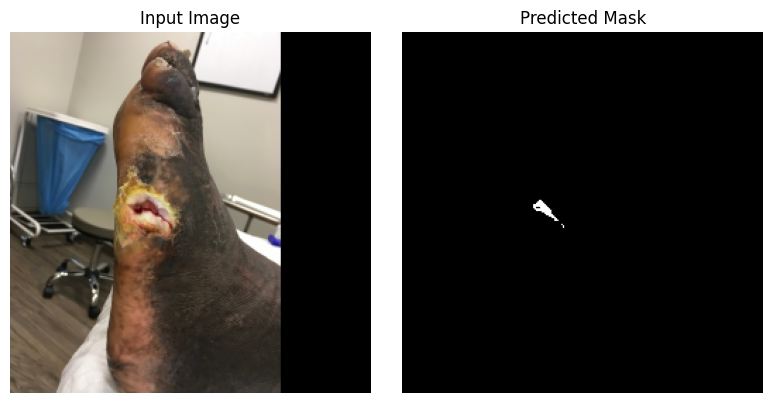

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


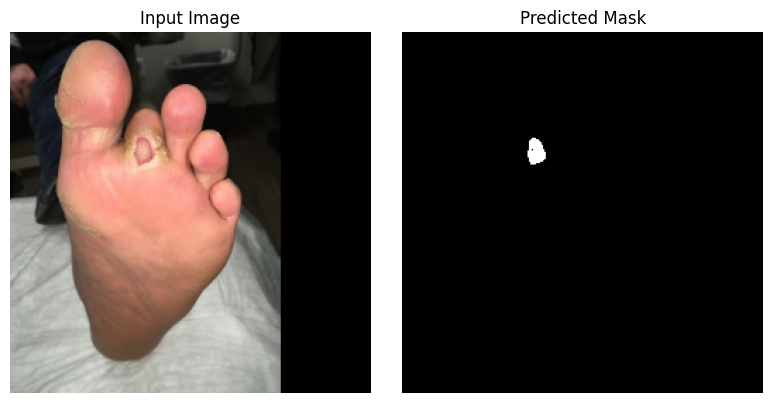

In [ ]:
# Visualize a few predictions
n_samples = 10
indices = np.random.choice(len(test_gen), n_samples, replace=False)

for i in indices:
    img = test_gen[i][0]
    pred = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = (pred > 0.5).astype(np.uint8)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Blend Predicted Mask with Original Image (Overlay Visualization)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


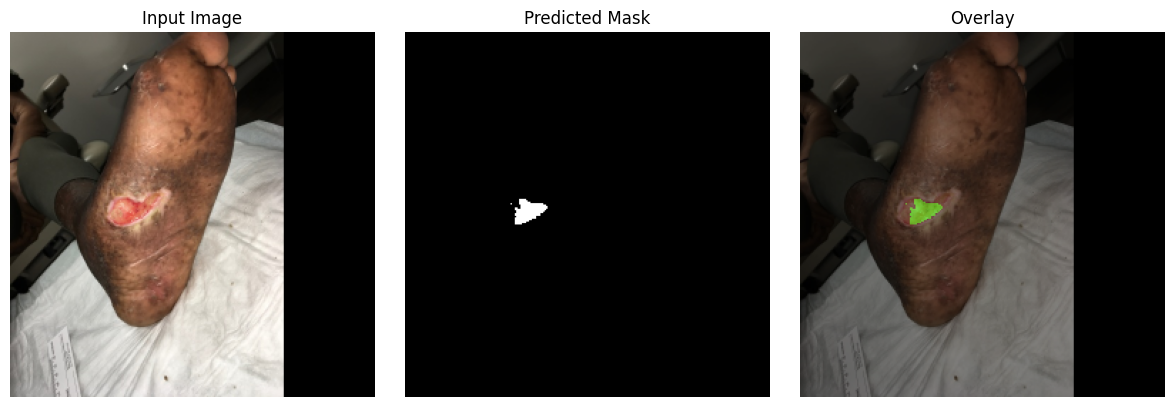

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


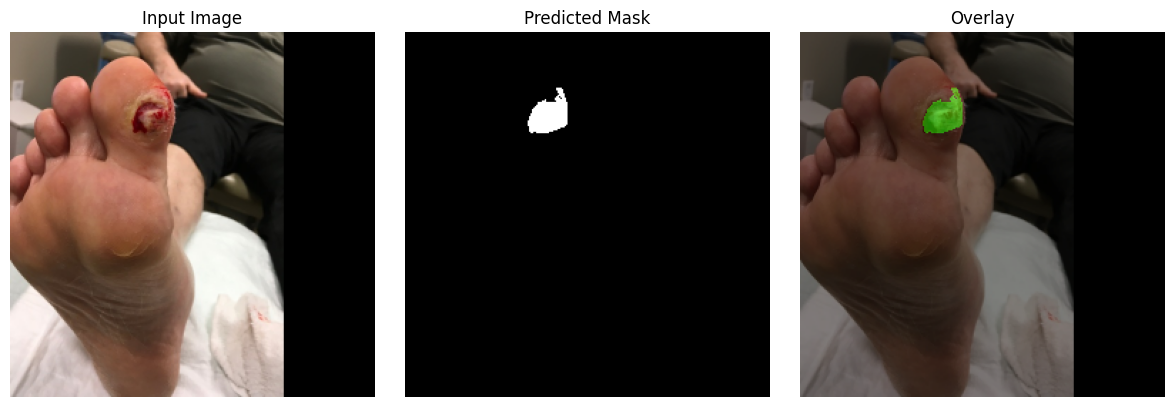

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


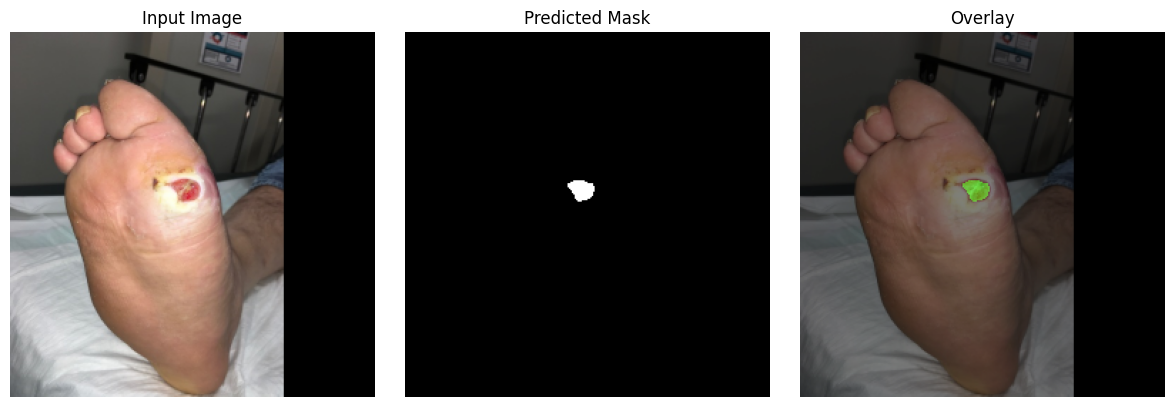

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


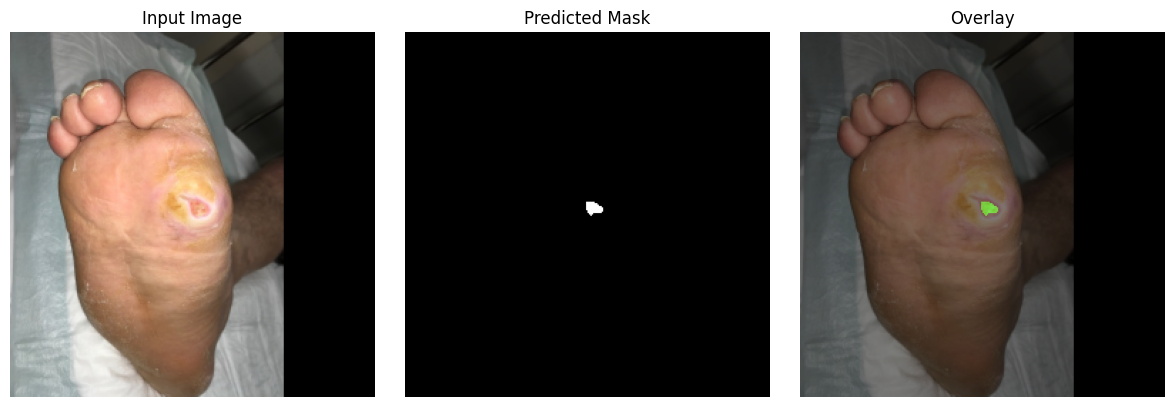

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


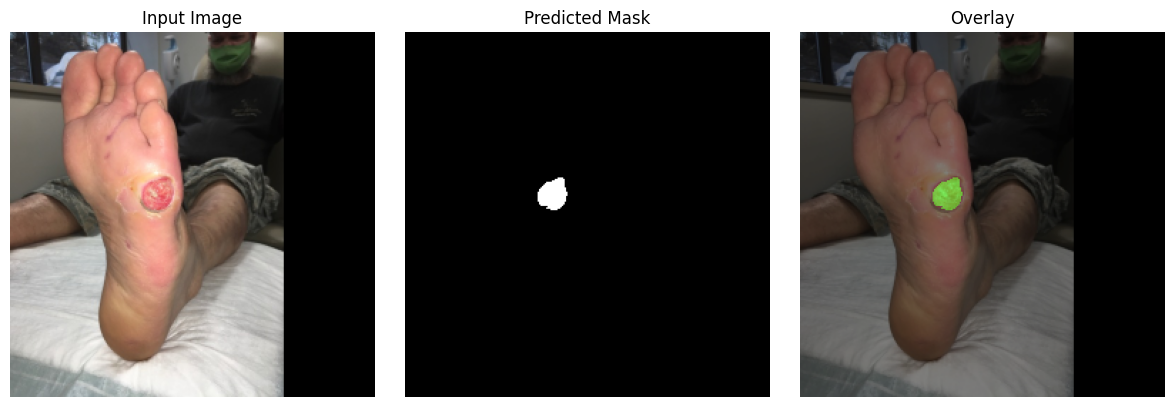

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


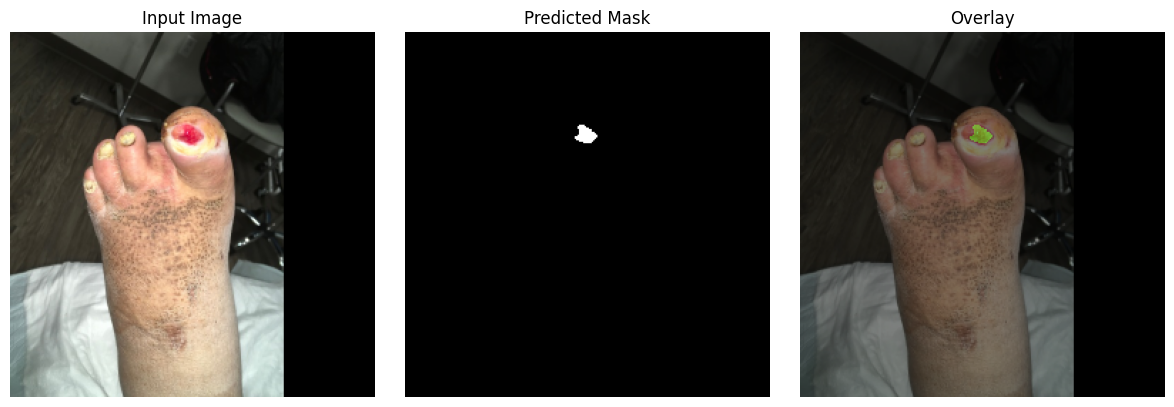

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


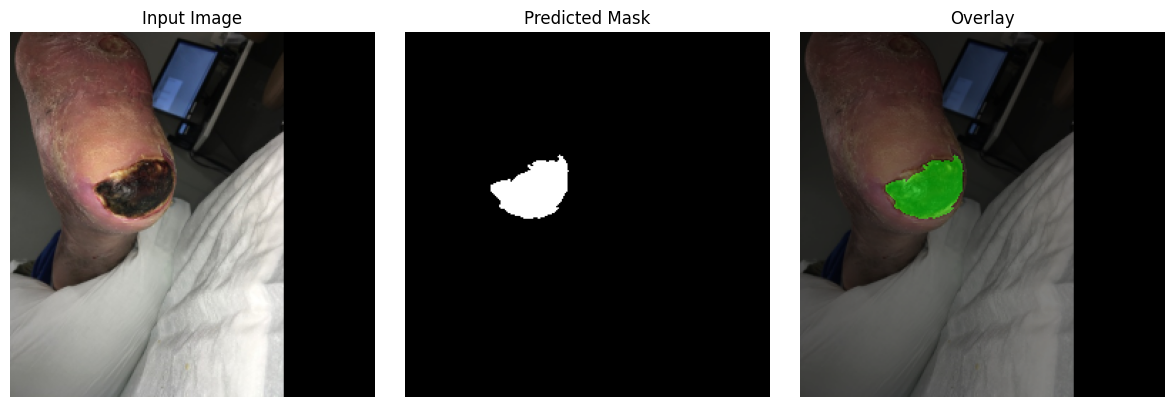

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


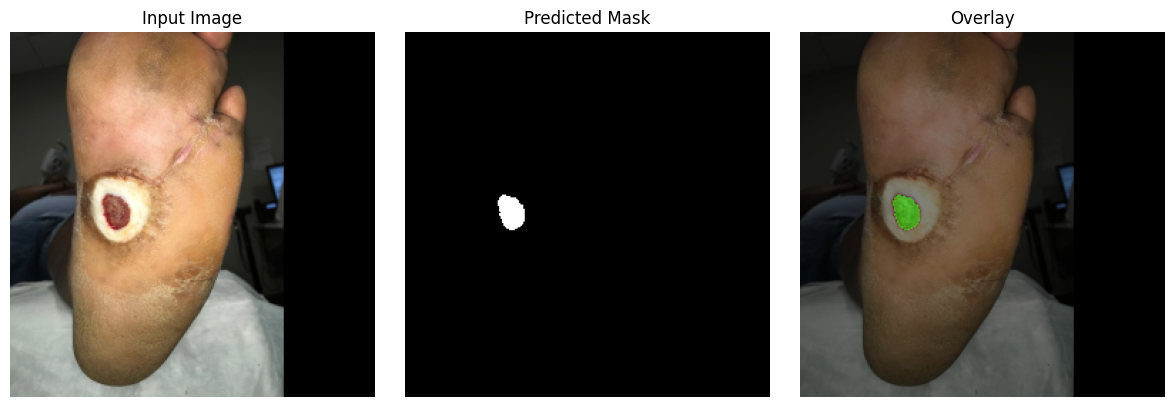

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


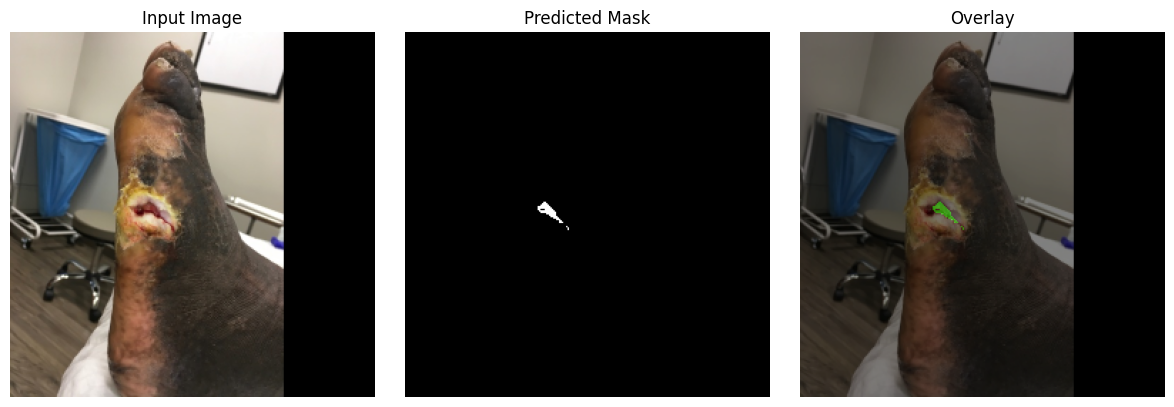

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


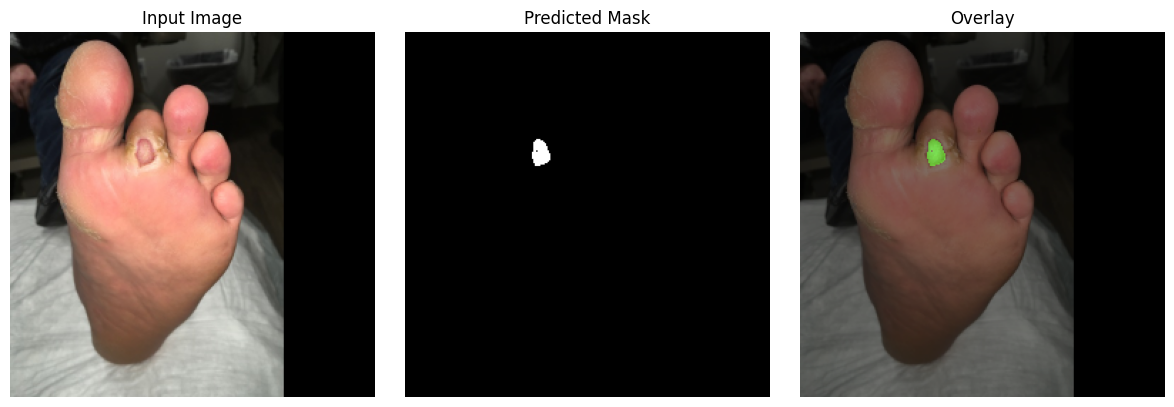

In [ ]:
import matplotlib.pyplot as plt

def blend_mask_on_image(image, mask, alpha=0.5):
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 1] = (mask.squeeze() * 255).astype(np.uint8)  # green overlay
    blended = cv2.addWeighted(image, 1 - alpha, mask_colored, alpha, 0)
    return blended

# Display overlay of prediction on input image
for i in indices:
    img = test_gen[i][0]
    pred = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = (pred > 0.5).astype(np.uint8)

    blended = blend_mask_on_image((img * 255).astype(np.uint8), pred_mask)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Export All Predictions as a ZIP File

In [ ]:
import zipfile

# Path to store the zip
zip_path = os.path.join(BASE_DIR, "predicted_masks.zip")

# Create a zip file of all predictions
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for filename in os.listdir(PRED_DIR):
        file_path = os.path.join(PRED_DIR, filename)
        zipf.write(file_path, arcname=filename)

print("All predicted masks saved to:", zip_path)


All predicted masks saved to: /content/drive/MyDrive/data/FootUlcerSegmentationChallenge/predicted_masks.zip


 Evaluate Model on Validation Set Using Dice, IoU, Accuracy

In [ ]:
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

# Collect all predictions and labels
all_preds = []
all_labels = []

for i in range(len(val_gen)):
    images, labels = val_gen[i]
    preds = model.predict(images)
    preds = (preds > 0.5).astype(np.uint8)
    labels = labels.astype(np.uint8)

    for j in range(len(preds)):
        pred_flat = preds[j].flatten()
        label_flat = labels[j].flatten()

        all_preds.extend(pred_flat)
        all_labels.extend(label_flat)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
iou = jaccard_score(all_labels, all_preds, zero_division=0)
dice = f1_score(all_labels, all_preds, zero_division=0)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation IoU:      {iou:.4f}")
print(f"Validation Dice:     {dice:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Validation Accuracy: 0.9971
Validation IoU:      0.7780
Validation Dice:     0.8751


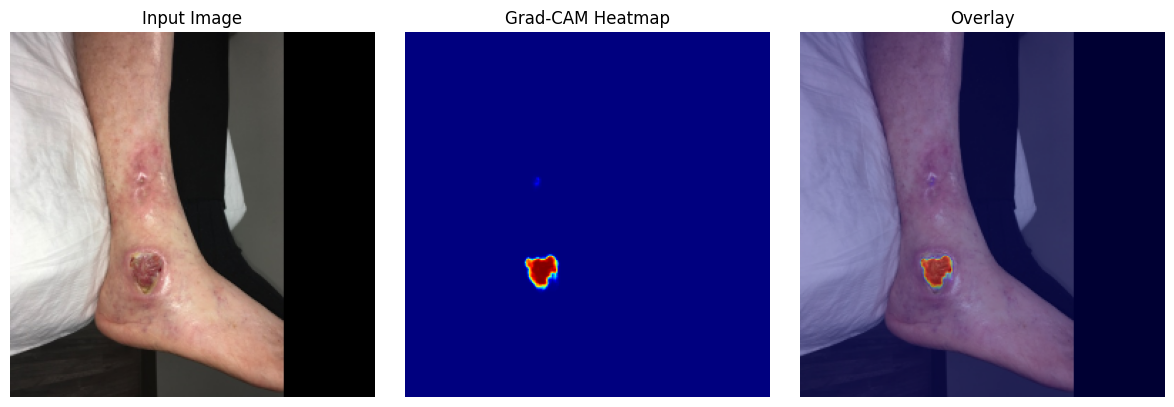

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

def get_gradcam(model, image, layer_name='conv2d_53'):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        # For segmentation, the 'loss' for Grad-CAM is often taken as the sum of the output pixels
        # that correspond to the predicted class (in this case, the ulcer class, which is 1)
        # We can approximate this by taking the sum of the prediction output for the target class channel.
        # Since it's binary segmentation with sigmoid output (channel 0), we can use that.
        loss = tf.reduce_sum(predictions[:,:,:,0]) # Assuming the ulcer is the first (and only) output channel

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]

    # Compute weights - average of gradients
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Normalize the heatmap
    cam = tf.maximum(cam, 0)
    cam = cam / (tf.reduce_max(cam) + 1e-8) # Add small epsilon for numerical stability
    cam = cam.numpy()

    # Resize heatmap to input image size
    heatmap = cv2.resize(cam, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    # Ensure image is in 0-255 range and uint8 type for blending
    image_uint8 = np.uint8(image * 255)
    # Convert image to BGR if it's RGB (cv2 works with BGR)
    if image_uint8.shape[-1] == 3:
      image_uint8 = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2BGR)

    overlay = cv2.addWeighted(image_uint8, 0.6, heatmap, 0.4, 0)

    # Convert overlay back to RGB for matplotlib display
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)


    return overlay, cam

# Example usage:
# Ensure test_gen has been initialized and contains data
if 'test_gen' in locals() and len(test_gen) > 0:
    # Get the first image from the test generator
    img = test_gen[0][0]  # Access the image data from the batch

    # Ensure the image is correctly shaped (H, W, C)
    if img.ndim == 4 and img.shape[0] == 1:
      img = img[0] # Remove batch dimension if present

    # Ensure the model exists and is loaded
    if 'model' in locals() and model is not None:
        try:
            overlay, cam_map = get_gradcam(model, img, layer_name='conv2d_53')  # Use the corrected layer name

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(cam_map, cmap='jet')
            plt.title("Grad-CAM Heatmap")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(overlay)
            plt.title("Overlay")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
        except ValueError as e:
             print(f"Could not generate Grad-CAM. Error: {e}")
             print("Please ensure the layer name 'conv2d_53' exists in your model.")
             print("Available layers:")
             for layer in model.layers:
                 print(layer.name)
    else:
        print("Model is not defined. Please run the cell to define and compile the model first.")
else:
    print("Test data generator 'test_gen' is not defined or empty. Please run the data generator initialization cell.")

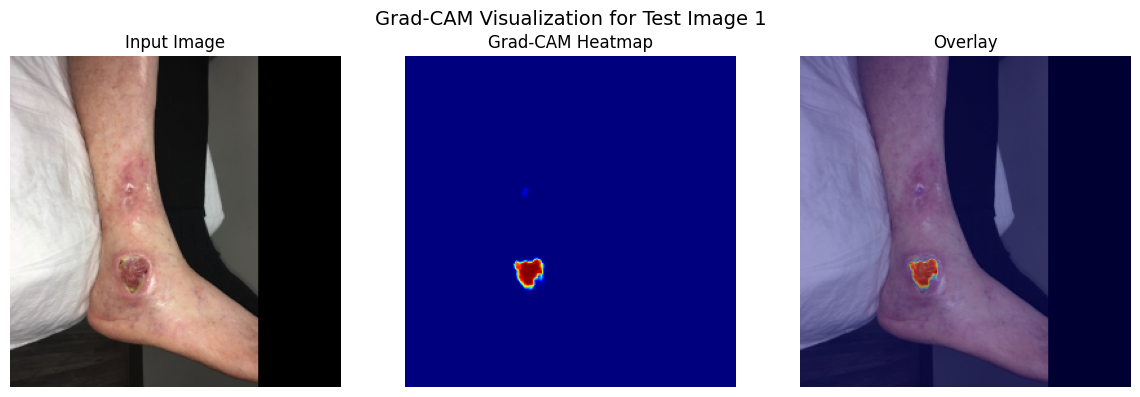

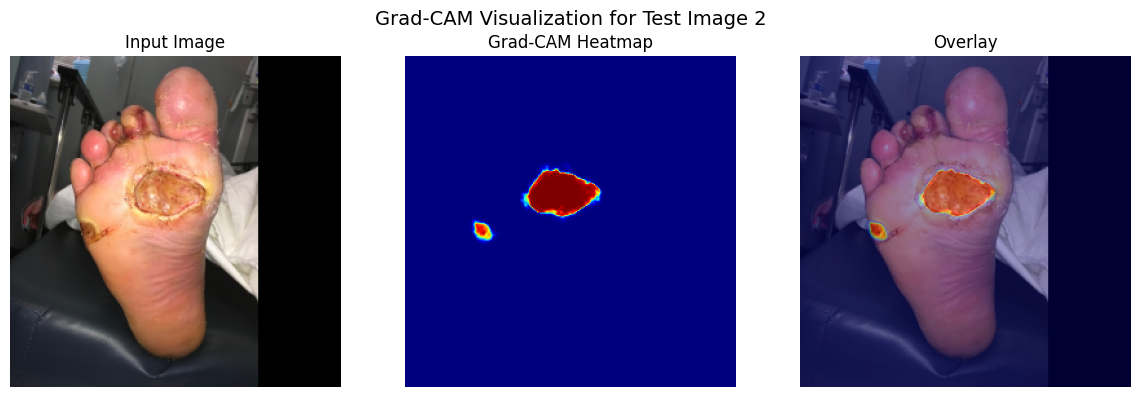

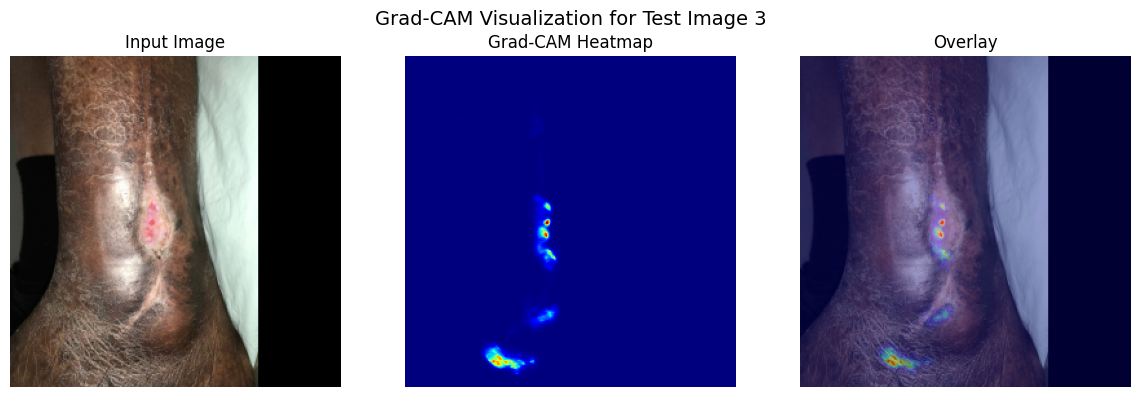

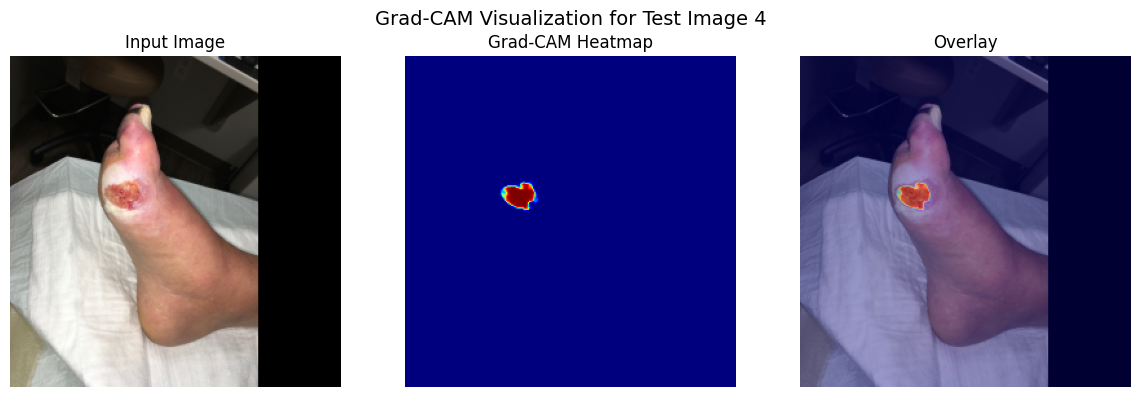

In [ ]:
# --- Loop through first 4 test images and generate Grad-CAM ---
if 'test_gen' in locals() and len(test_gen) > 0 and 'model' in locals() and model is not None:
    for i in range(4):
        try:
            img = test_gen[i][0]  # Get the i-th image batch

            if img.ndim == 4 and img.shape[0] == 1:
                img = img[0]

            overlay, cam_map = get_gradcam(model, img, layer_name='conv2d_53')  # Update layer name as needed

            plt.figure(figsize=(12, 4))
            plt.suptitle(f"Grad-CAM Visualization for Test Image {i+1}", fontsize=14)

            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(cam_map, cmap='jet')
            plt.title("Grad-CAM Heatmap")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(overlay)
            plt.title("Overlay")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"[Image {i+1}] Grad-CAM generation failed: {e}")
else:
    print("Model or test generator not properly defined.")
